Epoch [1/1500], Train Loss: 1627124.3412, Test Loss: 1004913.6250
Epoch [2/1500], Train Loss: 1624660.0270, Test Loss: 1002991.6875
Epoch [3/1500], Train Loss: 1622192.0822, Test Loss: 1001034.8125
Epoch [4/1500], Train Loss: 1619466.8423, Test Loss: 999061.0000
Epoch [5/1500], Train Loss: 1617379.9358, Test Loss: 997398.8750
Epoch [6/1500], Train Loss: 1615273.3525, Test Loss: 995724.8125
Epoch [7/1500], Train Loss: 1613152.0079, Test Loss: 994044.6250
Epoch [8/1500], Train Loss: 1611025.8919, Test Loss: 992363.6250
Epoch [9/1500], Train Loss: 1608899.5755, Test Loss: 990683.6875
Epoch [10/1500], Train Loss: 1606774.9144, Test Loss: 989006.0000
Epoch [11/1500], Train Loss: 1604652.8795, Test Loss: 987331.0000
Epoch [12/1500], Train Loss: 1602533.6520, Test Loss: 985658.5000
Epoch [13/1500], Train Loss: 1600417.4662, Test Loss: 983988.6875
Epoch [14/1500], Train Loss: 1598304.0946, Test Loss: 982321.6250
Epoch [15/1500], Train Loss: 1596193.7545, Test Loss: 980657.0000
Epoch [16/1500],

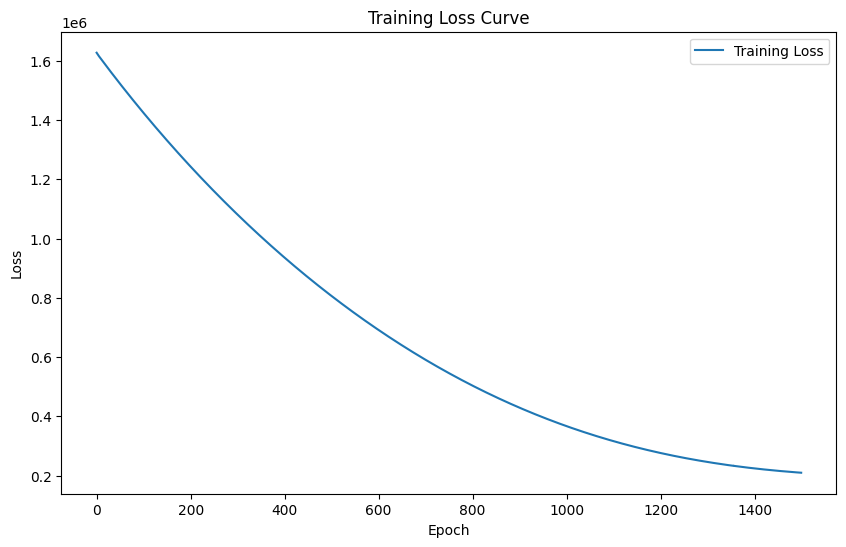

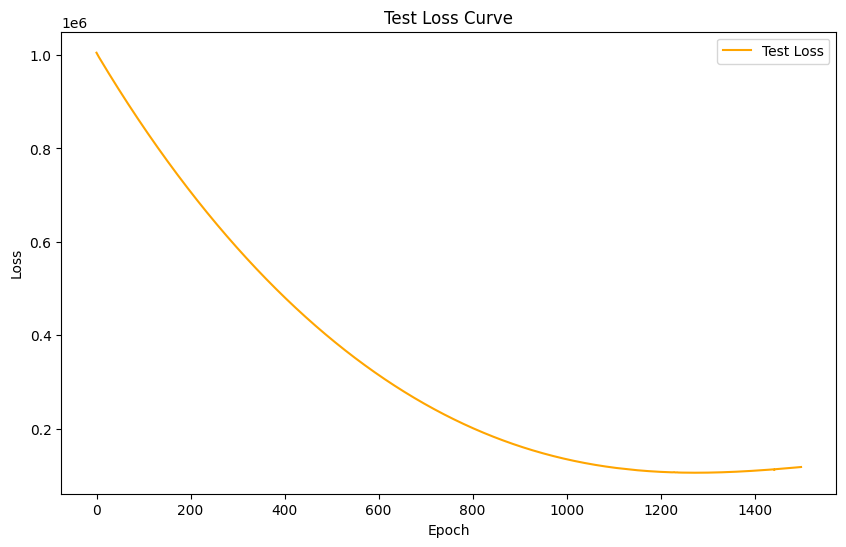

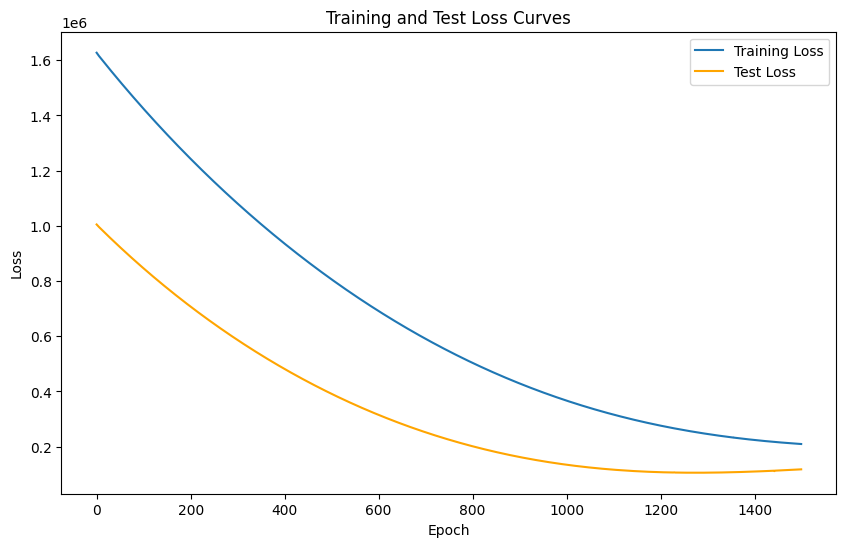

In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/FinalProjectDataS23.csv')

# Define window size and split the dataset
window_size = 10
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

# Create sequences and targets
def create_sequences_and_targets(data, window_size, train=True):
    sequences, targets = [], []
    start_index = window_size if train else len(data) - window_size

    for i in range(start_index, len(data)):
        sequence = data[i - window_size:i][['rate', 'ems', 'pkh']].values
        target = data.iloc[i]['pkh']
        sequences.append(sequence)
        targets.append(target)

    return sequences, targets

train_sequences, train_targets = create_sequences_and_targets(train_data, window_size)
test_sequences, test_targets = create_sequences_and_targets(test_data, window_size, train=False)

train_sequences = torch.tensor(train_sequences, dtype=torch.float32)
train_targets = torch.tensor(train_targets, dtype=torch.float32)
test_sequences = torch.tensor(test_sequences, dtype=torch.float32)
test_targets = torch.tensor(test_targets, dtype=torch.float32)

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

# Initialize the model
input_size = 3  # rate, ems, pkh
hidden_size = 128
output_size = 1  # predicting pkh
model = RNNModel(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1500
batch_size = 32

train_losses = []
test_losses = []

best_train_loss = float('inf')
best_test_loss = float('inf')

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_train_loss = 0.0
    for i in range(0, len(train_sequences), batch_size):
        batch_sequences = train_sequences[i:i+batch_size]
        batch_targets = train_targets[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(batch_sequences)
        loss = criterion(outputs, batch_targets.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item() * len(batch_sequences)

    train_loss = epoch_train_loss / len(train_sequences)
    train_losses.append(train_loss)

    # Evaluate on test dataset
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        test_outputs = model(test_sequences)
        test_loss = criterion(test_outputs, test_targets.unsqueeze(1))
        test_losses.append(test_loss.item())

    if train_loss < best_train_loss:
        best_train_loss = train_loss

    if test_loss < best_test_loss:
        best_test_loss = test_loss

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Print the best training and testing losses
print(f'Best Training Loss: {best_train_loss:.4f}')
print(f'Best Test Loss: {best_test_loss:.4f}')


# Plot training loss curve

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

# Plot test loss curve
plt.figure(figsize=(10, 6))
plt.plot(test_losses, label='Test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss Curve')
plt.legend()
plt.show()

# Plot both training and test loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curves')
plt.legend()
plt.show()